In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM,GRU
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D,MaxPooling1D,GlobalAveragePooling1D,Reshape
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
from sklearn.metrics import confusion_matrix, roc_auc_score,precision_recall_curve
from sklearn.metrics import classification_report,auc

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Using TensorFlow backend.


Python:  3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
pandas:  0.23.4
numpy:  1.19.1
seaborn:  0.9.0
matplotlib:  2.2.3
sklearn:  0.19.2
Keras:  2.3.1
Tensorflow:  2.1.0


In [2]:
df = pd.read_csv("../data/occupancy.txt", sep=",", index_col=None)
#dt = pd.read_csv("art_daily_jumpsdown.csv", sep=",", index_col=None)
print(df.shape)
pd.options.display.max_columns = None
df.head(5)

(2380, 2)


,timestamp,value
0,2015-09-01 13:45:00,3.06
1,2015-09-01 13:50:00,6.44
2,2015-09-01 13:55:00,5.17
3,2015-09-01 14:00:00,3.83
4,2015-09-01 14:05:00,4.50


In [3]:
train=df[df['value']<6]
train=train['value']
train=np.array(train)
timesquence=10
trim=len(train)%timesquence
train=train[:len(train)-trim]
train.shape=(int(len(train)/timesquence),timesquence,1)
print("train",train.shape)


train (175, 10, 1)


In [4]:
test=df['value']
test_label=[]
abnormal=0
normal=0
for i in range(len(test)):
    if(test.iloc[i]>15 ):
        test_label.append(1)
        test.iloc[i]=test.iloc[i]+20
        normal+=1
    else:
        abnormal+=1
        test_label.append(0)
            
    
print(len(test_label))
test=np.array(test)
trim=len(test)%timesquence
test_label=test_label[:len(test)-trim]
test=test[:len(test)-trim]
test.shape=(int(len(test)/timesquence),timesquence,1)

F:\anaconda\anac\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2380


In [43]:
LSTM

metric = 'mean_absolute_error'
model = Sequential()
model.add(LSTM(units=32, activation='relu', input_shape=(timesquence, 1), return_sequences=True))
#model.add(LSTM(units=16, activation='relu', input_shape=(timesquence, 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
 
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 10, 32)            4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 10, 1)             33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [125]:
metric = 'mean_absolute_error'
model = Sequential()
model.add(GRU(units=32, activation='relu', input_shape=(timesquence, 1), return_sequences=True))
model.add(GRU(units=16,activation='relu', return_sequences=True))
model.add(GRU(units=8,activation='relu', return_sequences=True))
model.add(Dropout(0.5))  
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 10, 32)            3264      
_________________________________________________________________
gru_11 (GRU)                 (None, 10, 16)            2352      
_________________________________________________________________
gru_12 (GRU)                 (None, 10, 8)             600       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 8)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 10, 1)             9         
Total params: 6,225
Trainable params: 6,225
Non-trainable params: 0
_________________________________________________________________
None


In [148]:
from keras.layers import  Lambda
n_filters = 32 
filter_width = 2

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq
x = Conv1D(filters=n_filters,
               kernel_size=filter_width,
             padding='causal',
              activation='relu')(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)
# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]
pred_seq_train = Lambda(slice, arguments={'seq_length':timesquence})(x)

model = Model(history_seq, pred_seq_train)
model.compile(optimizer=optimizers.Adam(), loss='mean_absolute_error')
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
dense_16 (Dense)             (None, None, 128)         4224      
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
dense_17 (Dense)             (None, None, 1)           129       
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1)           0         
Total params: 4,449
Trainable params: 4,449
Non-trainable params: 0
_________________________________________________________

In [149]:

history=model.fit(train, train,
                  batch_size=32,#32,32,
                   epochs=15,#30 30,
                    validation_data=(test, test))



Train on 175 samples, validate on 238 samples
Epoch 1/15
175/175 [==============================] - 3s 16ms/step - loss: 2.4629 - val_loss: 3.5053
Epoch 2/15
175/175 [==============================] - 0s 638us/step - loss: 1.8814 - val_loss: 2.6335
Epoch 3/15
175/175 [==============================] - 0s 707us/step - loss: 1.3614 - val_loss: 1.8968
Epoch 4/15
175/175 [==============================] - 0s 644us/step - loss: 0.9161 - val_loss: 1.3403
Epoch 5/15
175/175 [==============================] - 0s 695us/step - loss: 0.6967 - val_loss: 1.0920
Epoch 6/15
175/175 [==============================] - 0s 684us/step - loss: 0.6402 - val_loss: 0.8550
Epoch 7/15
175/175 [==============================] - 0s 638us/step - loss: 0.4859 - val_loss: 0.5943
Epoch 8/15
175/175 [==============================] - 0s 707us/step - loss: 0.3783 - val_loss: 0.5019
Epoch 9/15
175/175 [==============================] - 0s 1ms/step - loss: 0.3024 - val_loss: 0.2200
Epoch 10/15
175/175 [==================

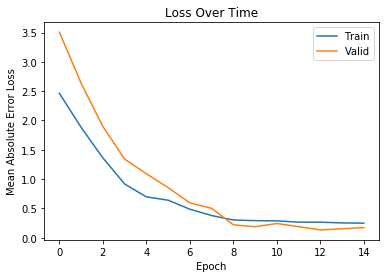

In [150]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [151]:
test_pred = model.predict(test)
print(test_pred.shape)
# print(test[0:5])
# print("-------------------------")
# print(test_pred[0:5])


(238, 10, 1)


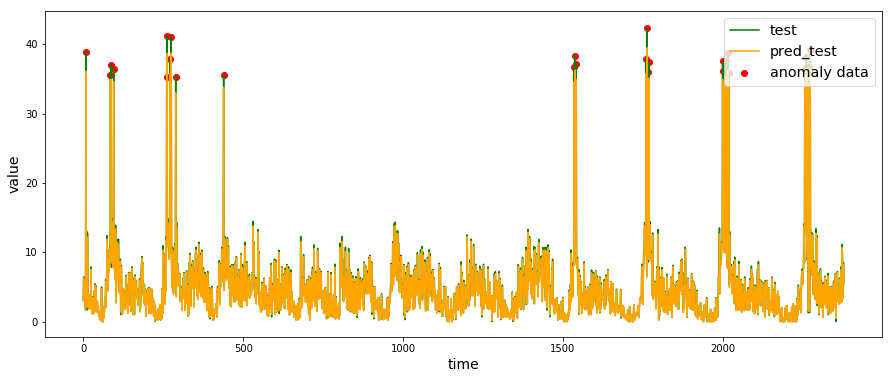

In [152]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(10)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,2)
plt.plot(test1[0:],color="green")
plt.plot(test_pred1[0:],color="orange",linestyle='-')
for i in range(len(test1)):
    if test_label[i] == 1:
        plt.scatter(i,test1[i],color="red")          
plt.legend(('test','pred_test','anomaly data'),loc='upper right',fontsize='x-large')


In [165]:
#点集检测
pred_label=[]
for i in range(len(test1)):
    pred_label.append(0)#正常

PAsum_rela_erro=np.zeros((len(pred_label)), dtype = float)
for i in range(len(pred_label)):
    PAsum_rela_erro[i]=np.abs(test1[i]-test_pred1[i])
PAscores=PAsum_rela_erro.copy()
PAscores.sort()
print(PAscores)


[2.92348862e-05 6.11114502e-05 1.71689987e-04 ... 2.62500183e+00
 2.69383438e+00 2.79399612e+00]


In [166]:
print(PAscores[500])

0.02869038343429564


In [167]:
PAcutoff=int(0.96*len(PAscores))
PAthreshold=PAscores[PAcutoff]
print(PAscores[PAcutoff])

0.49259914398193416


In [168]:
for i in range(len(test1)):
    if PAsum_rela_erro[i] > PAthreshold:
        pred_label[i]=2 #异常

In [157]:
normal_rela_erro=0.15
#集体集检测
timestep=6
n=int(len(pred_label)/timestep)
CAsum_rela_erro=np.zeros(n+1, dtype = float)
for i in range(0,len(test1),timestep):
    for j in range(timestep):
            if ((i+j)<len(pred_label)) and (pred_label[i+j]==0):
                rela_erro=np.abs(test1[i+j]-test_pred1[i+j])
                CAsum_rela_erro[int(i/timestep)]=rela_erro+CAsum_rela_erro[int(i/timestep)]
              #  print()
            else:
                CAsum_rela_erro[int(i/timestep)]=normal_rela_erro+CAsum_rela_erro[int(i/timestep)]
                
                
CAscores=CAsum_rela_erro.copy()
CAscores.sort()



[0.0553395  0.06680304 0.09427448 0.09684659 0.09799885 0.09950675
 0.10301578 0.10797536 0.10829694 0.11375919 0.11481151 0.11498863
 0.12029947 0.12320007 0.12494855 0.12581574 0.12682646 0.12724997
 0.13126182 0.13334802 0.13376646 0.13430609 0.13500786 0.13546756
 0.13888463 0.13990146 0.14185596 0.14409031 0.14692808 0.1495957
 0.15077841 0.15456686 0.15732346 0.16120769 0.16207341 0.16221257
 0.16589738 0.17270946 0.17342682 0.17399334 0.17498297 0.17730732
 0.17839849 0.1793428  0.18206523 0.18366488 0.18668104 0.18891686
 0.19109098 0.19368093 0.19930026 0.20767565 0.21156964 0.21290469
 0.21967552 0.22379328 0.22467033 0.22567348 0.22881261 0.22882769
 0.23256136 0.23404652 0.23565418 0.24029044 0.240998   0.24295334
 0.2453617  0.24728861 0.24779339 0.2499633  0.25030462 0.25236643
 0.2548103  0.25538752 0.25752853 0.27908119 0.28009641 0.28301353
 0.28558558 0.28750052 0.28945478 0.29401403 0.29489969 0.31118152
 0.31414887 0.31534132 0.31773323 0.32218085 0.32929282 0.33163

In [158]:
CAcutoff=int(0.99*len(CAscores))
CAthreshold=24#CAscores[CAcutoff]
print(CAthreshold)

24


In [159]:
for i in range(n+1):
    if CAsum_rela_erro[i] > CAthreshold:
        for j in range(timestep):
            if i*timestep+j<len(pred_label) and pred_label[i*timestep+j]!=2:
                pred_label[i*timestep+j]=1
        

In [160]:
Perro_x=[]
Perro_y=[]
Cerro_x=[]
Cerro_y=[]
for i in range(len(test1)):
    if pred_label[i]==2:
        Perro_x.append(i)
        Perro_y.append(test1[i])
    elif pred_label[i]==1:
        Cerro_x.append(i)
        Cerro_y.append(test1[i])

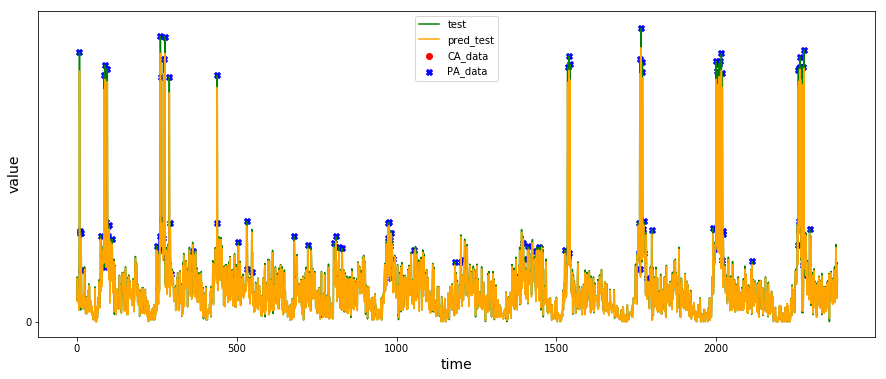

In [161]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,1000)
plt.plot(test1[0:],color="green",label='test')
plt.plot(test_pred1[0:],color="orange",linestyle='-',label='pred_test')
plt.scatter(Cerro_x,Cerro_y,color="red",label='CA_data')
plt.scatter(Perro_x,Perro_y,color="blue",marker="X",label='PA_data')          
plt.legend()


In [162]:
Pred_label=[]
for i in range(len(pred_label)):
    if pred_label[i]==0:
        Pred_label.append(0)
    else:
        Pred_label.append(1)

In [164]:
print("CA:",pred_label.count(1))
print("PA:",pred_label.count(2))
ROC=roc_auc_score(test_label,Pred_label)
print("ROC_AUC score:{:2%}".format(ROC))  
precision, recall, _thresholds = precision_recall_curve(test_label, Pred_label)
PR_AUC = auc(recall, precision)
print("PR-AUC score:{:2%}".format(PR_AUC)) 

CA: 0
PA: 118
ROC_AUC score:98.127660%
PR-AUC score:62.711864%


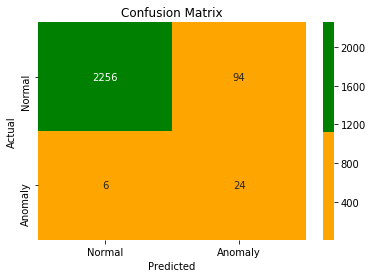

In [115]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(6, 4))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

viz = Visualization()
viz.draw_confusion_matrix(test_label,Pred_label)